# 0. 预处理

In [3]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from pathlib import Path
from typing import Optional, List
from torchvision.transforms.v2.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from torchvision.utils import flow_to_image
import pickle
from torchcodec.decoders import VideoDecoder
import cv2
import ot
import tempfile
import open_clip
import imageio
from IPython.display import Video, display
from evaluate import *

In [4]:
def plot(imgs):
    fig, axes = plt.subplots(nrows=len(imgs), ncols=len(imgs[0]), figsize=(len(imgs[0])*3, len(imgs)*2))
    axes = np.array(axes).reshape(len(imgs), len(imgs[0]))
    for i in range(len(imgs)):
        for j in range(len(imgs[i])):
            axes[i][j].imshow(imgs[i][j])
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.5)
    plt.show()

In [5]:
video_dir_path = Path(".") / "data/videos/BilibiliVideos/cpsfNCZVexQ"
video_path = video_dir_path / "video.mp4"
pkl_path = video_dir_path / "clips.pkl"
decoder = VideoDecoder(video_path)

In [50]:
def get_imgs(clip: VideoClip, frame_type: int):
    if frame_type == 0:
        frame = clip.start_frame
        saliency = clip.start_saliency
        flow = clip.start_flow
    elif frame_type == 1:
        frame = clip.end_frame
        saliency = clip.end_saliency
        flow = clip.end_flow
    else:
        raise ValueError()
        
    sim = Image.fromarray(saliency*255).convert('RGB')
    sim = sim.resize((decoder.metadata.width, decoder.metadata.height),resample=Image.BILINEAR)
    fim = Image.fromarray(flow_to_image(torch.tensor(flow)).permute(1, 2, 0).numpy()).convert('RGB')
    fim = fim.resize((decoder.metadata.width, decoder.metadata.height),resample=Image.BILINEAR)
    return [to_pil_image(decoder[frame]), sim, fim]

In [7]:
def show_clips(clips: List[VideoClip], fps = None):
    if not fps:
        fps = decoder.metadata.average_fps
    all_frames = []
    for clip in clips:
        all_frames.extend(decoder[clip.start_frame : clip.end_frame + 1])

    frames_tensor = torch.stack(all_frames)
    
    frames_np = frames_tensor.permute(0, 2, 3, 1).cpu().numpy()

    imageio.mimwrite("temp_video.mp4", frames_np, fps=fps, quality=8, macro_block_size=None)
    
    # 展示视频
    display(Video("temp_video.mp4", embed=True, width=300))

# 1. 获取数据

## 1.1 直接读取

In [8]:
with open(pkl_path, 'rb') as f:
    clips = pickle.load(f)

## 1.2 计算

In [1009]:
clips = decompose_clips(video_path)

成功切分 167 段 clip


### 1.2.1 计算显著性

In [7]:
calc_saliency(decoder, clips)

  0%|          | 0/5 [00:00<?, ?it/s]/home/keli/VideoEdit/U-2-Net/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


### 1.2.2 计算语义

In [8]:
calc_clip_embedding(decoder, clips)

100%|██████████| 17/17 [00:02<00:00,  7.24it/s]


### 1.2.3. 计算光流

In [9]:
calc_optical_flow(decoder, clips)

100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


### 1.2.4. 保存数据

In [10]:
with open(pkl_path, "wb") as f:
    pickle.dump(clips, f)

# 2. 分析

## 2.1 构图相似

In [42]:
def get_saliency_score(clip1: VideoClip, clip2: VideoClip, mode = 0, sigma = 0.2):
    dist = 0.0
    if mode == 0:
        dist = get_fast_emd(clip1.end_saliency, clip2.start_saliency)
    else:
        dist = get_pot_emd(clip1.end_saliency, clip2.start_saliency)
    
    return np.exp(-dist*dist / (2*sigma*sigma))

In [19]:
total = 0
for i in range(10):
    Sum = []
    idx_ord = list(range(0, len(clips)))
    import random
    random.shuffle(idx_ord)
    for i in range(1, len(clips)):
        Sum.append(get_saliency_score(clips[idx_ord[i-1]], clips[idx_ord[i]]))
    Sum = sorted(Sum, reverse=True)
    total += sum(Sum) / len(Sum)

print(total / 10)

0.781738


In [43]:
similarities = [(i, get_saliency_score(clips[i], clips[i + 1])) for i in tqdm(range(len(clips) - 1))]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
print(sum([x[1] for x in similarities]) / len(similarities))

100%|██████████| 440/440 [00:00<00:00, 12474.95it/s]

0.8118841


25 0.9295123
torch.Size([2, 64, 64])
torch.Size([2, 64, 64])


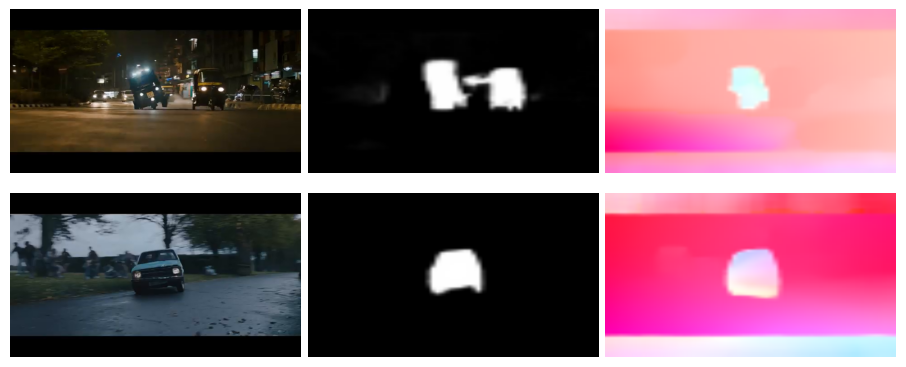

In [44]:
ith = 75
idx, score = similarities[ith]
idx = 25
print(idx, get_saliency_score(clips[idx], clips[idx+1]))
plot([get_imgs(clips[idx], 1), get_imgs(clips[idx + 1], 0)])

## 2.2 语义相似

In [21]:
Sum = []
idx_ord = list(range(0, len(clips)))
import random
random.shuffle(idx_ord)
for i in range(1, len(clips)):
    Sum.append(get_embeddings_score(clips[idx_ord[i-1]], clips[idx_ord[i]]))
Sum = sorted(Sum, reverse=True)
# print(Sum[int(len(Sum) * 0.2)])
print(sum(Sum) / len(Sum))

0.79537076


In [22]:
similarities = [(i, get_embeddings_score(clips[i], clips[i + 1])) for i in range(len(clips) - 1)]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
print(sum([x[1] for x in similarities]) / len(similarities))

0.9392601


0.9880261


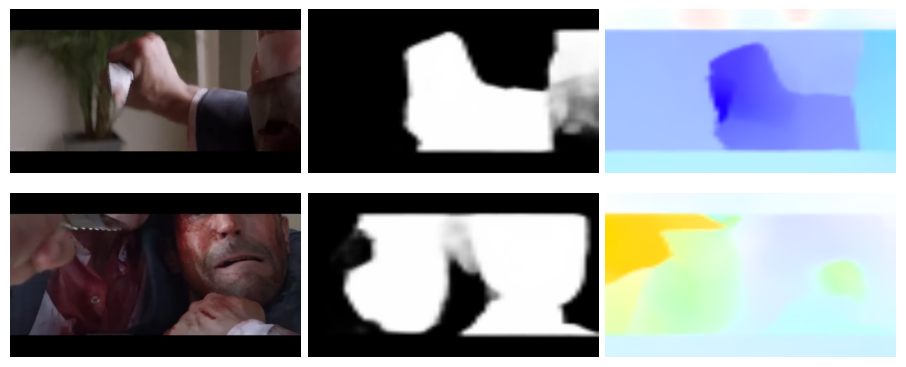

In [19]:
ith = 15
print(similarities[ith][1])
plot([get_imgs(clips[similarities[ith][0]], 1), get_imgs(clips[similarities[ith][0] + 1], 0)])

## 2.3 运动相似

In [53]:
def plot_two_distributions(H1, H2, title="Distribution Comparison"):
    bins = np.arange(len(H1))

    plt.figure(figsize=(8,4))
    plt.bar(bins, H1, width=0.4, alpha=0.6, label="H1")
    plt.bar(bins + 0.4, H2, width=0.4, alpha=0.6, label="H2")

    plt.title(title)
    plt.xlabel("Bin Index")
    plt.ylabel("Probability")
    plt.xticks(bins)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def _get_hoof_features(flow_field: np.ndarray, noise_threshold, static_ratio_threshold, bins: int = 36):
    """
    计算前景运动直方图 H 和运动像素占比 alpha。
    """
    u = flow_field[0]
    v = flow_field[1]
    
    # 1. 计算幅度和角度
    mag = np.sqrt(u**2 + v**2)
    angle = np.arctan2(v, u) # 角度在 -pi 到 pi
    
    # 2. 生成运动掩码 (前景分离)
    motion_mask = mag > noise_threshold
    total_pixels = flow_field.shape[1] * flow_field.shape[2]
    motion_ratio = np.sum(motion_mask) / total_pixels

    if motion_ratio < static_ratio_threshold:
        return np.zeros(bins), motion_ratio, 0.0
        
    # 4. 只处理运动像素 (Foreground-Only)
    valid_angles = angle[motion_mask]
    valid_mags = mag[motion_mask]
    
    # 5. 计算 Bin 索引
    angle_deg = (np.degrees(valid_angles) % 180 + 180) % 180 # 转换为 0-360 度
    bin_idx = (angle_deg / (180 / bins)).astype(int) % bins
    
    # 6. 计算 HOOF (使用 Magnitude 加权)
    hist = np.bincount(bin_idx, weights=valid_mags, minlength=bins)
    
    # 7. 归一化 (L1 范数)
    hist_norm = hist / (np.sum(hist) + 1e-8)
    
    return hist_norm, motion_ratio, np.mean(valid_mags)

idx = np.arange(36)
M = np.abs(idx[:, None] - idx[None, :])
M = np.minimum(M / 36, 1 - M / 36).astype(float)
def circular_emd_dist(H1, H2):
    return ot.emd2(H1, H2, M)

def get_motion_score(clip1, clip2, noise_threshold=2.0, static_ratio_threshold=0.02):    
    # 1. 提取 HOOF 特征和运动占比
    H1, alpha1, mean_mag1 = _get_hoof_features(clip1.end_flow, noise_threshold, static_ratio_threshold)
    H2, alpha2, mean_mag2 = _get_hoof_features(clip2.start_flow, noise_threshold, static_ratio_threshold)
    
    # 2. 静态状态判断 (Decoupling Logic)
    is_static1 = (alpha1 < static_ratio_threshold)
    is_static2 = (alpha2 < static_ratio_threshold)
    
    if is_static1 and is_static2:
        return 1.0
    if is_static1 != is_static2:
        # print(mean_mag1, mean_mag2)
        if is_static1:
            return np.exp(-mean_mag2/5)
        else:
            return np.exp(-mean_mag1/5)

    plot_two_distributions(H1, H2)

    dist = circular_emd_dist(H1, H2)
    return 1 - dist

In [9]:
cnt = 10
total = 0
for i in range(cnt):
    Sum = []
    idx_ord = list(range(0, len(clips)))
    import random
    random.shuffle(idx_ord)
    for i in range(1, len(clips)):
        Sum.append(get_motion_score(clips[idx_ord[i-1]], clips[idx_ord[i]]))
    Sum = sorted(Sum, reverse=True)
    total += sum(Sum) / len(Sum)

print(total / cnt)


0.54557884


In [48]:
similarities = [(i, get_motion_score(clips[i], clips[i + 1])) for i in range(len(clips) - 1)]
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

print(sum([x[1] for x in similarities]) / len(similarities))

0.63070154


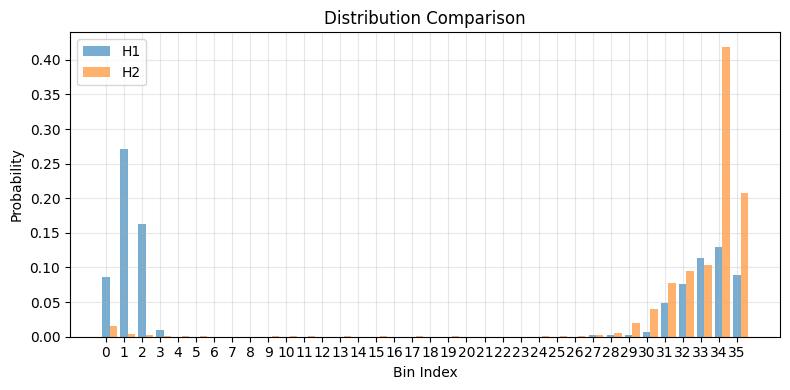

25 0.9471113554933523


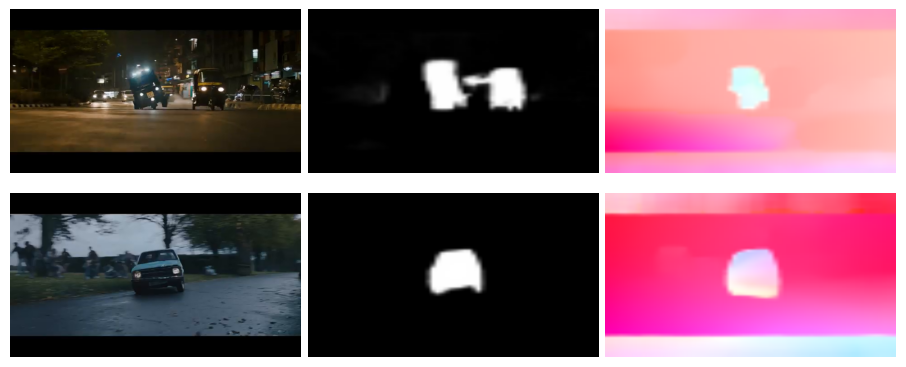

In [54]:
ith = 58
(idx, sim) = similarities[ith]
print(idx, get_motion_score(clips[idx], clips[idx + 1]))
plot([get_imgs(clips[idx], 1), get_imgs(clips[idx + 1], 0)])

In [42]:
show_clips([clips[idx], clips[idx + 1]], fps=30)

0.8891767859458923


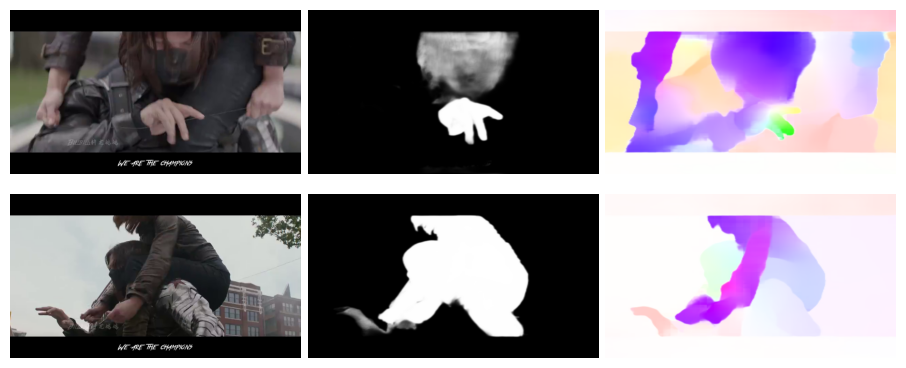

In [96]:
ith = 6
(idx, sim) = similarities[ith]
print(sim)
plot([get_imgs(clips[idx], 1), get_imgs(clips[idx + 1], 0)])

In [97]:
show_clips([clips[idx], clips[idx + 1]], fps=15)